In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scinet import *
import scinet.ed_copernicus as edc

### Plotting

In [2]:
def fix_jumps(theta_M):
    """
    Fixes jumps that arise because theta_M is always between -pi and pi
    """
    while True:
        diff = np.abs(theta_M[:, 1:] - theta_M[:, :-1])
        jumps = np.array(np.where(diff > 1.)).T
        if len(jumps) == 0:
            break
        fixed_lines = []
        for x, y in jumps:
            if x in fixed_lines:
                continue
            else:
                fixed_lines.append(x)
            theta_M[x, y + 1:] = theta_M[x, y + 1:] - np.sign(theta_M[x, y + 1] - theta_M[x, y]) * 2 * np.pi
    return theta_M

In [3]:
def copernicus_phi(net, series_length=20, delta_t=7, steps=50):
    layer = net.state_means
    ss = np.linspace(0, 2 * np.pi, num=steps)
    mm = np.linspace(0, 2 * np.pi, num=steps)
    S, M = np.meshgrid(ss, mm)
    data = edc.copernicus_data(series_length, delta_t=delta_t, phi_S_target=np.ravel(S), phi_M_target=np.ravel(M))[0]
    fig = plt.figure(figsize=(6.0, 2.8))
    fig.tight_layout()
    out = np.array(net.run(data, layer))
    for i in range(len(out[0])):
        zs = out[:, i]
        ax = fig.add_subplot('12{}'.format(i+1), projection='3d')
        ax.view_init(20, 60)
        Z = np.reshape(zs, S.shape)
        surf = ax.plot_surface(S, M, Z, rstride=1, cstride=1, cmap=cm.inferno, linewidth=0)
        ax.set_xlabel(r'$\phi_S$')
        ax.set_ylabel(r'$\phi_M$')
        ax.set_zlabel('Latent activation {}'.format(i + 1))
        ax.set_xticks([0, np.pi, 2*np.pi])
        ax.set_yticks([0, np.pi, 2*np.pi])
        ax.set_xticklabels(['0', r'$\pi$', r'$2 \pi$'])
        ax.set_yticklabels(['0', r'$\pi$', r'$2 \pi$'])
    return fig


In [4]:
def theta_fit(net, series_length, steps=100):
    R_E = 1.
    R_M = 1.524

    dist = lambda theta_S, theta_M: R_E * np.cos(theta_S - theta_M) + np.sqrt(R_M**2 - R_E**2 * np.sin(theta_S - theta_M)**2)
    phi_E = lambda theta_S, theta_M: theta_S
    phi_M = lambda theta_S, theta_M: np.angle(R_E / R_M * np.cos(theta_S) - dist(theta_S, theta_M) / R_M * np.cos(theta_M) +
                                              1.j * (R_E / R_M * np.sin(theta_S) - dist(theta_S, theta_M) / R_M * np.sin(theta_M)))
    theta_S_range = [0, 2 * np.pi]
    theta_M_range = [-np.pi, np.pi]

    theta_S, theta_M = np.meshgrid(np.linspace(*theta_S_range, num=steps), np.linspace(*theta_M_range, num=steps))

    in_theta = np.vstack([np.ravel(theta_S), np.ravel(theta_M)]).T
    in_zero = np.zeros([np.size(theta_S), (2 * series_length - 2)]) # padding to get right shape of input

    net_in = np.hstack([in_theta, in_zero])
    zs = net.run(net_in, net.state_means)

    phi_E_vals = phi_E(theta_S, theta_M)
    phi_M_vals = fix_jumps(phi_M(theta_S, theta_M).T).T

    coeffs = [] # coefficients for fitting the network output to a linear combination of phi_E and phi_M
    for i in range(2):
        A = np.vstack([np.ravel(phi_E_vals), np.ravel(phi_M_vals), np.ones(np.size(theta_S))]).T
        coeffs.append(np.linalg.lstsq(A, zs[:, i], rcond=None)[0])

    fig = plt.figure(figsize=(16.4, 12.2))
    for i in range(2):
        ax = fig.add_subplot('22{}'.format(2 * i + 1), projection='3d')
        ax.plot_surface(theta_S, theta_M, zs[:, i].reshape(theta_M.shape), cmap=cm.inferno)
        ax.set_xlabel(r'$\theta_S$')
        ax.set_ylabel(r'$\theta_M$')
        ax.set_zlabel('Latent activation {}'.format(i + 1))
        ax = fig.add_subplot('22{}'.format(2 * i + 2), projection='3d')
        fit_z = coeffs[i][0] * phi_E_vals + coeffs[i][1] * phi_M_vals + coeffs[i][2]
        ax.plot_surface(theta_S, theta_M, fit_z, cmap=cm.inferno)
        ax.set_xlabel(r'$\theta_S$')
        ax.set_ylabel(r'$\theta_M$')
        ax.set_zlabel(r'Fit ${:.2} \, \phi_E + {:.2} \, \phi_M + {:.2}$'.format(*coeffs[i]))
    return fig

## Load pre-trained model

### Parameters
- `latent_size: 2`
- `input_size: 1` 
- `output_size: 2`
- other parameters: default values
### Data
- random_start: False (uses realistic data that could have been collected during Copernicus' lifetime)
- Training data: 95000 samples with `delta_t: 7`
- Validation data: 5000 samples with `delta_t: 7`

### Training
1. 1000 epochs with `batch_size: 256`, `learning_rate: 1e-4`, `beta: 0.1`, `euler_l2_coeff: 1`, `time_series_length: 20`
2. 1000 epochs with `batch_size: 1024`, `learning_rate: 1e-4`, `beta: 0.1`, `euler_l2_coeff: 1`, `time_series_length: 20`
3. 1000 epochs with `batch_size: 1024`, `learning_rate: 1e-4`, `beta: 0.1`, `euler_l2_coeff: 1`, `time_series_length: 50`
4. 1000 epochs with `batch_size: 2048`, `learning_rate: 1e-5`, `beta: 0.01`, `euler_l2_coeff: 1`, `time_series_length: 50`
5. 11000 epochs with `batch_size: 2048`, `learning_rate: 1e-5`, `beta: 0.001`, `euler_l2_coeff: 1`, `time_series_length: 50`

In [5]:
net = nn.Network.from_saved('copernicus', change_params={'name': 'copernicus'})

{'decoder_num_units': [100, 100], 'tot_epochs': 15000, 'latent_size': 2, 'output_size': 2, 'time_series_length': 50, 'encoder_num_units': [100, 100], 'euler_num_units': [], 'input_size': 1, 'load_file': 'copernicus', 'name': 'copernicus'}







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








INFO:tensorflow:Restoring parameters from /home/jrwest/Courses/Winter_2021/CS230/project/nn_physical_concepts_cs230/tf_save/copernicus.ckpt
Loaded network from file copernicus


In [12]:
# print network attributes
print(net.input_size)
print(net.latent_size)
print(net.encoder_num_units)
print(net.decoder_num_units)
print(net.tot_epochs)
print(net.output_size)
print(net.rnn_depth)

1
2
[100, 100]
[100, 100]
15000
2
49


## Plot of latent activation as a function of observed angles

Each row of the following plots corresponds to one latent neuron. Within each row, the plot on the left shows the activation of this latent neuron as a function of the observed angled $\theta_S$ and $\theta_M$. The right plot shows a fit of the latent activation to a linear combination $\phi_S(\theta_S, \theta_M)$, $\phi_M(\theta_S, \theta_M)$ (see Fig. 6a in paper for the definition of $\theta$ and $\phi$). The fact that the plots within every row look similar confirms again that SciNet has learnt a linear combination of the heliocentric angles $\phi$.

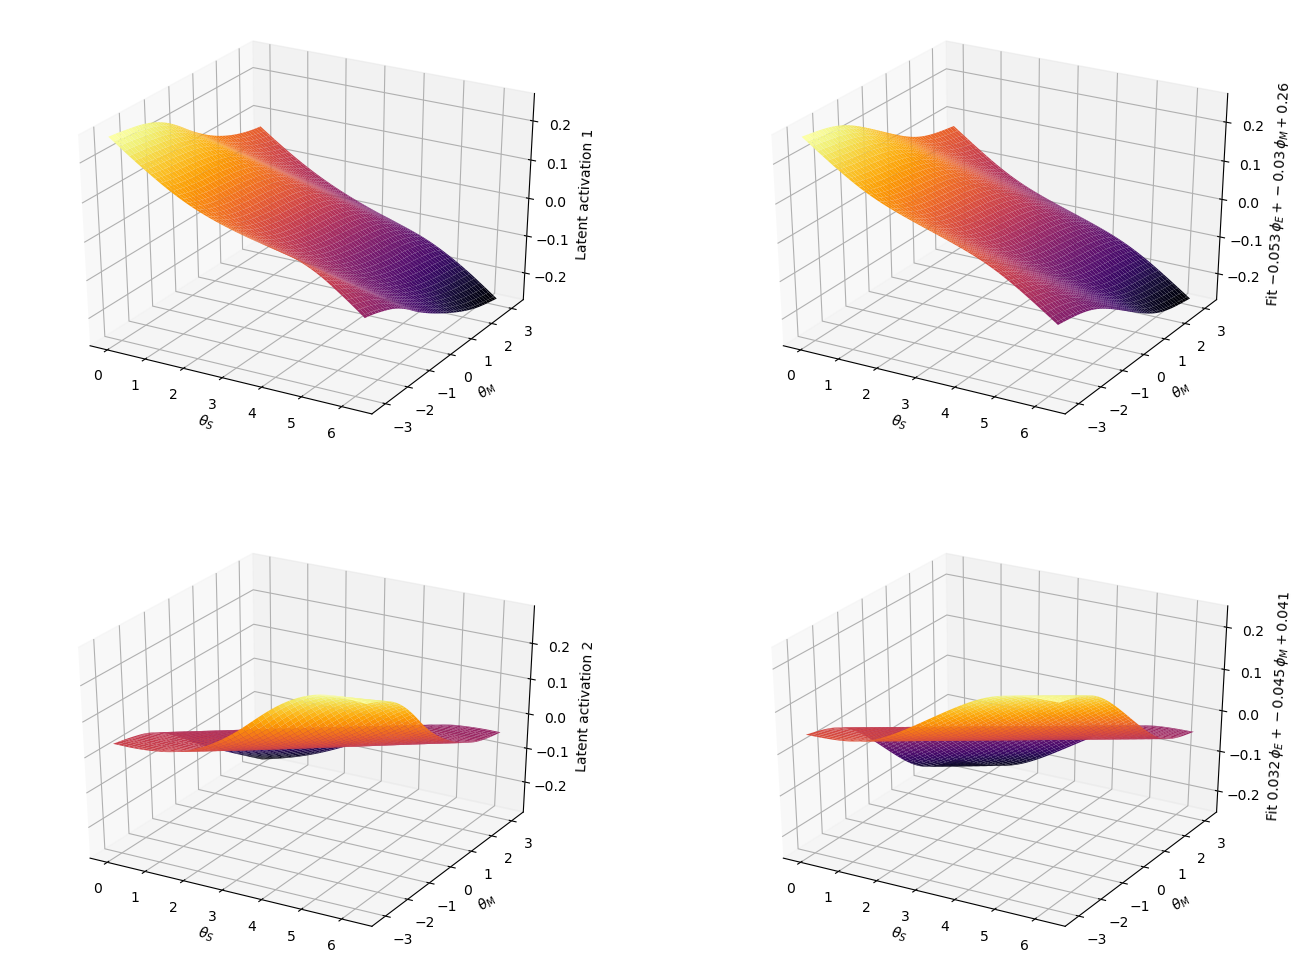

In [6]:
%matplotlib tk
theta_fit(net, 50)

## Plot of latent activation as a function of heliocentric angles

In [7]:
%matplotlib tk
fig = copernicus_phi(net, series_length=50)

### Calculate L2-norm of error

In [8]:
data, states = edc.copernicus_data(50, 50000)

In [9]:
np.sqrt(net.run(data, net.recon_loss))

0.01917553